# Training

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import os
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

print("CUDA available - ", torch.cuda.is_available())

num_classes = 157  
size = 720, 1280

transform = transforms.Compose([
    transforms.Resize((size)), 
    # сделать grayscale or HSV, чтобы исключить HUE
    transforms.ToTensor()
])

#Custom target transform to convert dictionary to appropriate format
class TargetTransform:
    def __init__(self, num_classes=num_classes):
        self.num_classes = num_classes
        self.one_hot_encoder = OneHotEncoder(categories=[range(num_classes)], sparse=False)
        self.one_hot_encoder.fit([[0]])  

    def __call__(self, target):
        # Perform one-hot encoding for class labels
        class_label = [[target['class']]]
        class_label = self.one_hot_encoder.transform(class_label)
        class_label = torch.tensor(class_label, dtype=torch.float32)

        return {
            'boxes': torch.tensor(target['boxes']),  # Reshape to [num_boxes, 4]
            'labels': torch.tensor(class_label)
        }

class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None, is_train = True):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.is_train = is_train

        if self.is_train:
            self.data = self.data[self.data['image_type'] == 0]
        else:
            self.data = self.data[self.data['image_type'] == 1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        new_width, new_height = size[1], size[0]

        orig_width, orig_height = image.size
        x_scale = new_width / orig_width 
        y_scale = new_height / orig_height
        
        x, y, width, height = self.data.iloc[idx, 1:5]
        boxes = [x * x_scale,
                y * y_scale,
                width * x_scale,
                height * y_scale]
        # make one-hot encoding for label 

        boxes = torch.tensor(boxes, dtype=torch.float32)
        boxes = torch.stack([boxes[0], boxes[1], boxes[2], boxes[3]])

        if self.transform:
            image = self.transform(image)  # Apply transform to image, resize, and toTensor

        targets = {
            'boxes': boxes,  # Add batch dimension
            'labels': int(self.data.iloc[idx, 7]),
        }

        return image, targets


train_dataset = TrafficSignDataset(csv_file = 'A:/Профиль/Rab Table/Учёба/3/анализ изображений/курс/files/full-gt2.csv',
                                   img_dir = 'A:/Профиль/Rab Table/Учёба/3/анализ изображений/курс/files/train_images/rtsd-frames/',
                                   transform=transform,
                                   target_transform=TargetTransform(num_classes=num_classes),
                                   is_train = True)

validation_dataset = TrafficSignDataset(csv_file = 'A:/Профиль/Rab Table/Учёба/3/анализ изображений/курс/files/full-gt2.csv',
                                        img_dir = 'A:/Профиль/Rab Table/Учёба/3/анализ изображений/курс/files/validation_images/rtsd-frames/',
                                        transform=transform,
                                        target_transform=TargetTransform(num_classes=num_classes),
                                        is_train = False)

print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(validation_dataset))

# Load the pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.RAdam(model.parameters(), lr=10 ** -4, weight_decay=10 ** -4)
#optimizer = optim.SGD(model.parameters(), lr=10 ** -4, momentum=0.9, weight_decay=10 ** -4)
batch_size = 4

subset_size = 250
train_indices = list(range(len(train_dataset)))
#train_indices = train_indices[:subset_size]
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)

validation_indices = list(range(len(validation_dataset)))
#validation_indices = validation_indices[:subset_size]
validation_sampler = SubsetRandomSampler(validation_indices)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=batch_size,
                                                sampler=validation_sampler)

CUDA available -  True
Train dataset size: 95492
Validation dataset size: 8866


c:\Users\artem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\artem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for i, (images, targets) in enumerate(train_loader):
        #print('images.shape:', images.shape, 'targets:', targets)
        #print(counter)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in targets.items()}]
        optimizer.zero_grad()

        targetsss = []
        for j in range(len(images)):
            d = {}
            d['boxes'] = targets[0]['boxes'][j].view(1, 4)
            d['labels'] = targets[0]['labels'][j].view(-1)
            targetsss.append(d)
    
        loss_dict = model(images, targetsss)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {losses.item():.4f}')
        # print all losses in dict
        for k, v in loss_dict.items():
            print(k, v)
        print('')


# Save the trained model
torch.save(model.state_dict(), 'traffic_sign_detection_model.pth')


Epoch [1/10], Step [1/23873], Loss: 5.2086
loss_classifier tensor(5.1257, device='cuda:0', grad_fn=<NllLossBackward0>)
loss_box_reg tensor(0.0375, device='cuda:0', grad_fn=<DivBackward0>)
loss_objectness tensor(0.0429, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss_rpn_box_reg tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)

Epoch [1/10], Step [2/23873], Loss: 5.1833
loss_classifier tensor(5.0680, device='cuda:0', grad_fn=<NllLossBackward0>)
loss_box_reg tensor(0.0196, device='cuda:0', grad_fn=<DivBackward0>)
loss_objectness tensor(0.0804, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss_rpn_box_reg tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)

Epoch [1/10], Step [3/23873], Loss: 5.0976
loss_classifier tensor(5.0284, device='cuda:0', grad_fn=<NllLossBackward0>)
loss_box_reg tensor(0.0174, device='cuda:0', grad_fn=<DivBackward0>)
loss_objectness tensor(0.0505, device='cuda:0',
       grad_fn=<BinaryCrossEntro

KeyboardInterrupt: 

In [6]:
# make predictions on the validation dataset. Build confusion matrix
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes = 157)
model.load_state_dict(torch.load("A:/Профиль/Загрузки/small_50.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# calculate IoU for each pair of boxes
def calculate_iou(box1, box2):
    box1 = box1[0]
    try:
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
    except:
        print(box1, box2)
        raise Exception
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # calculate union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area

    # calculate IoU
    iou = intersection_area / union_area

    return iou

y_true = []
y_pred = []
iou_list = []

for images, targets in validation_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in targets.items()}]
    outputs = model(images)
    for i in range(len(outputs)):
        ### LABELS ###
        labels = [x.item() for x in outputs[i]['labels']]
        scores = [x.item() for x in outputs[i]['scores']]
        y_true.append(targets[0]['labels'][i].item())
        #print(targets[0]['labels'][i].item())

        if len(labels) == 0:
            y_pred.append(-1)
        else:
            y_pred.append(labels[scores.index(max(scores))])

        ### IOU ###
        boxes = [x.tolist() for x in outputs[i]['boxes']]
        scores = [x.tolist() for x in outputs[i]['scores']]
        if len(boxes) == 0:
            iou_list.append(0)
        else:
            max_score_index = scores.index(max(scores))
            max_score_box = boxes[max_score_index * 4: (max_score_index + 1) * 4]
            iou_list.append(calculate_iou(max_score_box, targets[0]['boxes'][i].cpu().numpy()))

c:\Users\artem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\artem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# save y_true and y_pred, iou_list
import pickle
with open('y_true.pickle', 'wb') as f:
    pickle.dump(y_true, f)
with open('y_pred.pickle', 'wb') as f:
    pickle.dump(y_pred, f)
with open('iou_list.pickle', 'wb') as f:
    pickle.dump(iou_list, f)

# Evaluation

In [7]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for i in range(num_classes):
    tp = np.sum((y_true == i) & (y_pred == i))
    fp = np.sum((y_true != i) & (y_pred == i))
    fn = np.sum((y_true == i) & (y_pred != i))
    tn = np.sum((y_true != i) & (y_pred != i))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if tp + fp + fn == 0:
        f1 = 0
    else:
        f1 = 2 * tp / (2 * tp + fp + fn)
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    f1_list.append(f1)

accuracy_array = np.array(accuracy_list)
recall_array = np.array(recall_list)
f1_array = np.array(f1_list)

In [8]:
print('Accuracy:', np.mean(accuracy_array))
print('Precision:', np.mean(precision_list))
print('Recall:', np.mean(recall_array))
print('F1:', np.mean(f1_array))


Accuracy: 0.9948116399729303
Precision: 0.3473809860499702
Recall: 0.33201694217044714
F1: 0.30950417083134224


In [9]:
# build confusion matrix 
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(f'mIoU: {np.mean(iou_list):.4f}')
print(f'mIoU (non-zero): {np.mean([x for x in iou_list if x > 0]):.4f}')
print(f'max IoU: {max(iou_list):.4f}')

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
# delete all empty rows (NaN)
cm = cm[~np.isnan(cm).any(axis=1)]


mIoU: 0.4350
mIoU (non-zero): 0.7730
max IoU: 0.9848


C:\Users\artem\AppData\Local\Temp\ipykernel_17916\2101039988.py:13: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


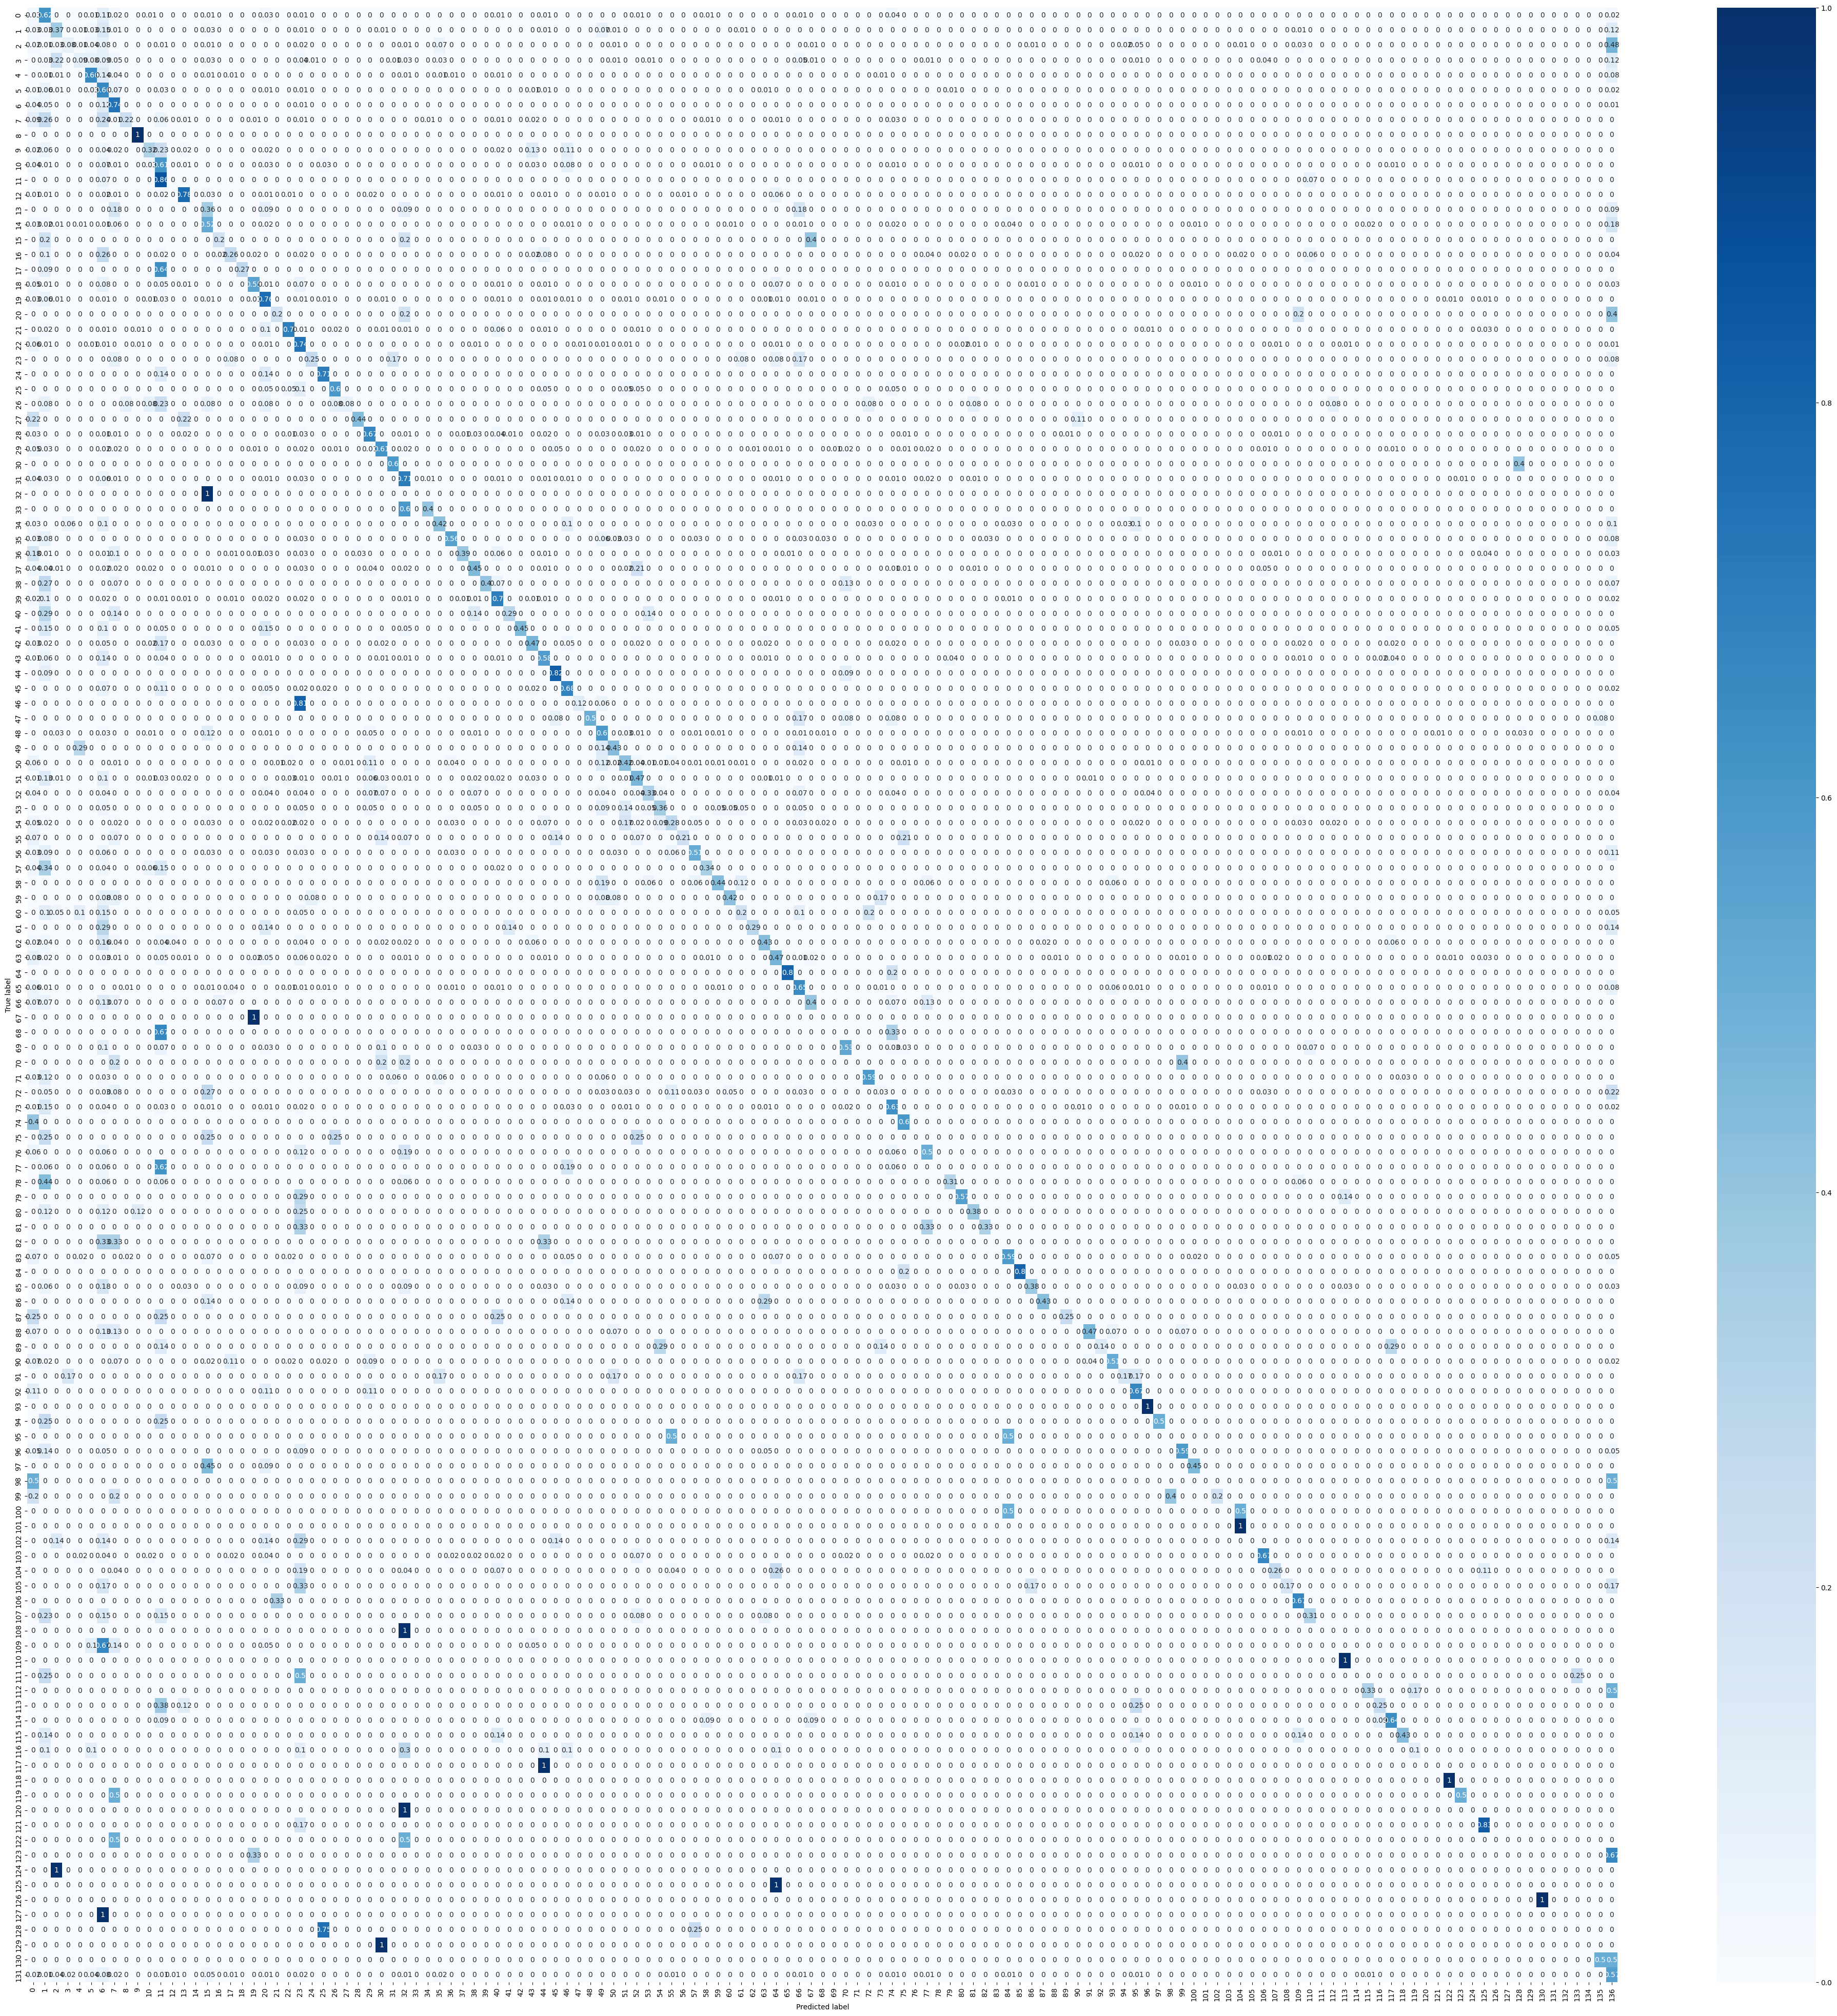

In [10]:
plt.figure(figsize=(50, 50))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [10]:
# print num of classes in validation dataset
print('Number of classes in validation dataset:', len(set(y_true)))
print(len(validation_dataset))
print(len(y_true))
# print sum of -1 in y_true
print('Number of -1 in y_true:', np.sum(y_pred == -1))

Number of classes in validation dataset: 42
8866
250
Number of -1 in y_true: 8


In [3]:
torch.save(model.state_dict(), '123.pth')

# Prediction

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes = 157)
model.load_state_dict(torch.load('123.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

[{'boxes': tensor([[1131.4309,  110.7737, 1271.7628,  212.5831],
        [1140.0519,  104.2388, 1267.4546,  216.1736],
        [1136.2668,  101.5338, 1264.7799,  218.9632]], device='cuda:0'), 'labels': tensor([ 52, 101,   2], device='cuda:0'), 'scores': tensor([0.7697, 0.1388, 0.1328], device='cuda:0')}]


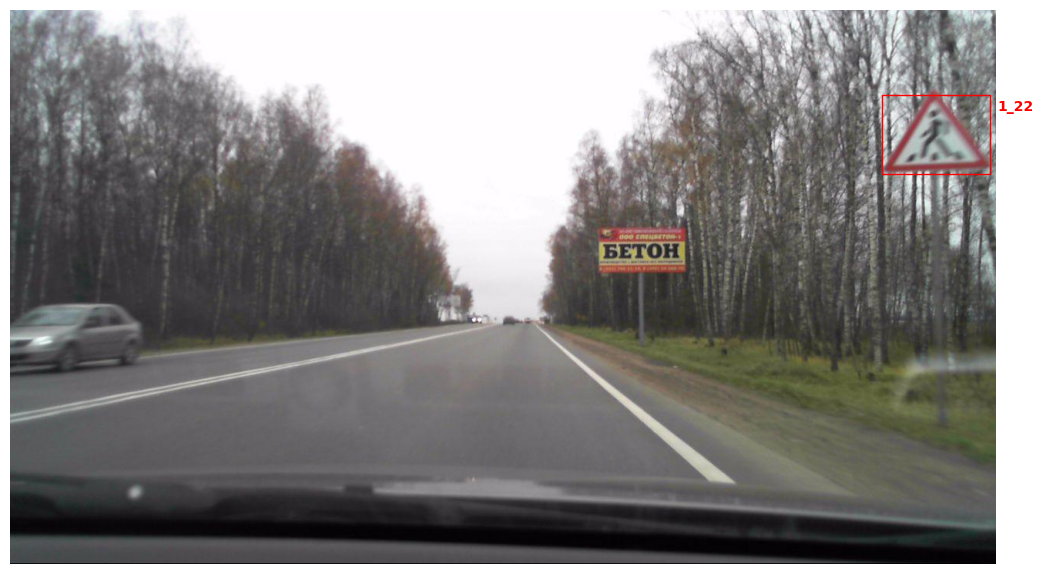

In [32]:
# make a prediction on a single image and plot the result
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch, torchvision
import json

# load image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_path = "A:/autosave23_10_2012_10_05_39_0.jpg"
img = Image.open(img_path).convert('RGB')
orig_img = img.copy()
signs_json = json.load(open('A:/Профиль/Rab Table/Учёба/3/анализ изображений/курс/files/label_map.json'))
# get image size
orig_width, orig_height = img.size
img = transform(img)
transformed_width, transformed_height = img.shape[1], img.shape[2]
# scale ratio
x_scale = orig_width / transformed_width
y_scale = orig_height / transformed_height
img = img.unsqueeze(0)
img = img.to(device)

# load model and weights
'''
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes = 157)
model.load_state_dict(torch.load('123.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#'''

# get predictions
model.eval()
with torch.no_grad():
    predictions = model(img)
print(predictions)

# plot predictions
fig, ax = plt.subplots(1)
#ax.imshow(orig_img)
ax.imshow(transforms.ToPILImage()(img.squeeze(0).cpu()))


for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
    if score > 0.4:
        # box to cpu
        box = box.cpu()
        # find the key by value (label.item()) in the dictionary (signs_json)
        try:
            sign = list(signs_json.keys())[list(signs_json.values()).index(label.item())]
        except:
            sign = '-1'

        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[2] + 10, box[1] + 20, f'{sign}', color='red', fontsize=10, fontweight='bold')
# show without axis
plt.axis('off')
# set resolution 1280x720 for saving
fig.set_size_inches(12.8, 7.2)
plt.show()